# 1. Business Understanding

**Цель:** Построить систему детекции аномалий в финансовых транзакциях, способную классифицировать операции как нормальные или подозрительные, минимизируя пропуск мошеннических операций при приемлемом уровне ложных тревог.


**Желаемые итоги:**
- снижать финансовые потери банка и клиентов,
- ускорять реакцию на мошеннические операции,
- повышать доверие пользователей к системе.

**Метрики:**
- Precision - точность, т.е доля предсказанных “аномалий”, которая действительно была таковой
- Recall - полнота, показывает сколько реальных аномалий операций удалось идентифицировать
- F1 - балансная метрика между Precision и Recall
- ROC-AUC - оценивает насколько хорошо модель разделяет классы.
- PR-AUC - насколько модель выявляет редкий положительный класс


# 2. Data Understanding

##Структура предложенного датасета:
| поле           | описание                                                                         |
| ----------------------- | ------------------------------------------------------------------------------------------ |
| transaction_id          | Уникальный идентификатор транзакции                                                        |
| timestamp               | Дата и время транзакции (в формате ISO YYYY-MM-DD HH:MM:SS)                                |
| customer_id             | Псевдонимизированный идентификатор клиента                                                 |
| issuer_bank             | Банк-эмитент (например: MAIB, Moldindconbank, Victoriabank, OTP Bank Moldova и др.)        |
| account_type            | Тип счёта: индивидуальный или бизнес                                                       |
| card_type               | Тип карты: дебетовая или кредитная                                                         |
| product_tier            | Уровень продукта: Standard, Gold, Platinum                                                 |
| region                  | Район или муниципий в Молдове (включая Кишинёв, Бельцы, Гагаузию)                          |
| urban                   | Городской статус проживания: 1 = город, 0 = село                                           |
| age                     | Возраст клиента (в годах)                                                                  |
| tenure_months           | Стаж клиента в банке (в месяцах)                                                           |
| cluster_id_expected     | ID ожидаемого поведенческого кластера для обычных транзакций                               |
| cluster_name_expected   | Название ожидаемого поведенческого кластера                                                |
| channel                 | Канал транзакции: POS, eCommerce, ATM, P2P, Wire, MPay                                     |
| merchant_category       | Торговая категория (например: Grocery, Electronics, Utilities/MPay и т.д.)                 |
| merchant_country        | Страна торговых операций (ISO-2; MD — для внутренних операций)                                      |
| currency                | Валюта транзакции (MDL, EUR, USD, RON, UAH, TRY, GBP)                                      |
| fx_rate_to_mdl          | Курс конверсии в MDL (зависит от года и валюты)                                            |
| amount_txn_ccy          | Сумма транзакции в исходной валюте                                                         |
| amount_mdl              | Сумма транзакции в MDL после конверсии                                                     |
| card_present            | Признак присутствия карты: 1 = да (POS/ATM/MPay), 0 = нет                                  |
| auth_method             | Метод аутентификации: CHIP, CONTACTLESS, MAGSTRIPE, 3DSecure, TOKENIZED, STRONG_AUTH, NONE |
| is_3ds                  | Признак 3D Secure (только для eCommerce): 1 = да, 0 = нет                                  |
| three_ds_result         | Результат 3DS: OK, CHALLENGE, FAILED, NA                                                   |
| device_type             | Тип устройства: mobile_app, web, physical_card                                             |
| device_trust_score      | Оценка надёжности устройства (0–1; выше = безопаснее)                                      |
| ip_risk_score           | Оценка риска IP (0–1; выше = больший риск)                                                 |
| geo_distance_km         | Расстояние до базовой локации клиента (в км)                                               |
| hour_of_day             | Час суток (0–23)                                                                           |
| day_of_week             | День недели (0 = понедельник … 6 = воскресенье)                                            |
| is_night                | Ночная транзакция (00:00–05:59): 1 = да, 0 = нет                                           |
| is_weekend              | Транзакция в выходной: 1 = да, 0 = нет                                                     |
| txn_count_1h            | Количество транзакций за последний час                                                     |
| txn_amount_1h_mdl       | Сумма транзакций за последний час (в MDL)                                                  |
| txn_count_24h           | Количество транзакций за последние 24 часа                                                 |
| txn_amount_24h_mdl      | Сумма транзакций за последние 24 часа (в MDL)                                              |
| merchant_risk_score     | Оценка торгового риска (0–1)                                                                |
| velocity_risk_score     | Оценка риска по скорости операций (0–1)                                                    |
| new_device_flag         | Новый ли это девайс: 1 = да, 0 = нет                                                       |
| cross_border            | Транзакция международная: 1 = да (страна ≠ MD), 0 = нет                                    |
| campaign_q2_2025        | Признак участия в eCommerce-кампании Q2 2025: 1 = да, 0 = нет                              |
| amount_log_z            | Z-score по логарифму суммы (используется для поиска выбросов)                              |
| anomaly_score_synth     | Синтетический аномальный скор (0–1; выше = подозрительнее)                                 |
| is_suspect_unsup        | Метка из несупервизорного метода: 1 = подозрительная (топ 5%), 0 = нормальная              |
| is_anomaly_ground_truth | Истинная метка аномалии: 1 = аномалия, 0 = норма                                           |
| anomaly_type            | Тип аномалии (например: ECOM_NIGHT_NO3DS_HIGHAMT, VELOCITY_BURST и т.д.)                   |


## Выявлено 6 видов аномалий:
- ECOM_NIGHT_NO3DS_HIGHAMT - незащищенные ночные транзакции на большую сумму
- VELOCITY_BURST - всплеск активности
- RARE_COUNTRY_CCY - редкие комбинации страна + валюта
- IMPOSSIBLE_TRAVEL - несовпадение страны с географическим расстоянием
- POS_MAGSTRIPE_NIGHT - ночная покупка в магазине через магнитную полосу
- NEW_DEVICE_IP_CROSS - заграничная транзакция с нового устройства с подозрительным IP

## Загружаем датасет и видим, что он содержит 29 численных полей и 17 объектных.

In [2]:
import pandas as pd

def auto_read_csv(path: str) -> pd.DataFrame:
    best = None
    for sep in [';', ',', '\t', '|']:
        try:
            df_try = pd.read_csv(path, sep=sep, encoding='utf-8')
        except Exception:
            continue
        print(f"Разделитель '{sep}' -> форма {df_try.shape}")
        if best is None or df_try.shape[1] > best.shape[1]:
            best = df_try
    if best is None:
        raise RuntimeError("Не удалось прочитать CSV.")
    print("Данные загружены:", best.shape)
    return best


CSV_PATH = 'moldova_payments_suspicious.csv'

df = auto_read_csv(CSV_PATH)
df.info()
df.describe()

Разделитель ';' -> форма (30000, 1)
Разделитель ',' -> форма (30000, 46)
Разделитель '	' -> форма (30000, 1)
Разделитель '|' -> форма (30000, 1)
Данные загружены: (30000, 46)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 46 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transaction_id           30000 non-null  object 
 1   timestamp                30000 non-null  object 
 2   customer_id              30000 non-null  object 
 3   issuer_bank              30000 non-null  object 
 4   account_type             30000 non-null  object 
 5   card_type                30000 non-null  object 
 6   product_tier             30000 non-null  object 
 7   region                   30000 non-null  object 
 8   urban                    30000 non-null  int64  
 9   age                      30000 non-null  int64  
 10  tenure_months            30000 non-null  int64  
 11  cluster_i

,urban,age,tenure_months,cluster_id_expected,fx_rate_to_mdl,amount_txn_ccy,amount_mdl,card_present,is_3ds,device_trust_score,...,txn_amount_24h_mdl,merchant_risk_score,velocity_risk_score,new_device_flag,cross_border,campaign_q2_2025,amount_log_z,anomaly_score_synth,is_suspect_unsup,is_anomaly_ground_truth
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,0.627733,37.756267,39.603200,1.861000,3.443880,1534.411079,1754.618001,0.616767,0.208800,0.747754,...,1301.183967,0.317114,0.057485,0.112633,0.064567,0.033933,4.666667e-07,0.620590,0.050000,0.030133
std,0.483417,11.499215,40.132494,1.657881,6.065198,3608.950784,3817.390014,0.486183,0.406458,0.125538,...,635.362141,0.152056,0.087098,0.316149,0.245764,0.181061,1.000016e+00,0.097726,0.217949,0.170957
min,0.000000,18.000000,0.000000,0.000000,0.450000,1.870000,22.230000,0.000000,0.000000,0.020000,...,82.140000,0.004000,0.000000,0.000000,0.000000,0.000000,-3.449000e+00,0.307500,0.000000,0.000000
25%,0.000000,29.000000,11.000000,0.000000,1.000000,293.482500,431.127500,0.000000,0.000000,0.675000,...,856.660000,0.203000,0.000000,0.000000,0.000000,0.000000,-7.010000e-01,0.551200,0.000000,0.000000
50%,1.000000,38.000000,28.000000,1.000000,1.000000,692.380000,851.555000,1.000000,0.000000,0.764000,...,1201.740000,0.299000,0.020000,0.000000,0.000000,0.000000,-6.200000e-02,0.612900,0.000000,0.000000
75%,1.000000,46.000000,55.000000,3.000000,1.000000,1543.945000,1774.685000,1.000000,0.000000,0.839000,...,1621.940000,0.414000,0.090000,0.000000,0.000000,0.000000,6.280000e-01,0.681300,0.000000,0.000000
max,1.000000,82.000000,360.000000,5.000000,22.700000,187906.870000,187906.870000,1.000000,1.000000,0.996000,...,10089.880000,1.000000,1.000000,1.000000,1.000000,1.000000,5.010000e+00,0.971200,1.000000,1.000000


## Проверка на пустые значения и дубликаты

In [3]:
df.isna().sum()

,0
transaction_id,0
timestamp,0
customer_id,0
issuer_bank,0
account_type,0
card_type,0
product_tier,0
region,0
urban,0
age,0


 Поле three_ds_result содержит 23736 NA, но они имеют смысл там в качестве "нет данных о результатах"

Убираем дубликаты, если такие есть

In [4]:
df = df.drop_duplicates()
df

,transaction_id,timestamp,customer_id,issuer_bank,account_type,card_type,product_tier,region,urban,age,...,merchant_risk_score,velocity_risk_score,new_device_flag,cross_border,campaign_q2_2025,amount_log_z,anomaly_score_synth,is_suspect_unsup,is_anomaly_ground_truth,anomaly_type
0,TX900000,2025-02-02 21:50:55,CUST350000,MAIB,Individual,Credit,Standard,Hîncești,1,50,...,0.566,0.16,0,0,0,-0.840,0.5603,0,0,NORMAL
1,TX900001,2025-08-23 22:21:25,CUST350001,Comertbank,Individual,Debit,Standard,Edineț,1,37,...,0.263,0.06,0,0,0,1.289,0.6702,0,0,NORMAL
2,TX900002,2024-01-15 08:14:16,CUST350002,Energbank,Individual,Debit,Standard,Ștefan Vodă,1,27,...,0.307,0.32,0,0,0,0.782,0.6722,0,0,NORMAL
3,TX900003,2025-08-09 20:23:46,CUST350003,MAIB,Individual,Credit,Standard,Drochia,0,41,...,0.454,0.00,0,0,0,-0.155,0.5551,0,0,NORMAL
4,TX900004,2025-03-10 22:11:12,CUST350004,Moldindconbank,Business,Debit,Standard,Soroca,1,51,...,0.246,0.00,0,0,0,1.535,0.8143,1,1,POS_MAGSTRIPE_NIGHT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,TX929995,2025-02-01 00:00:34,CUST379995,MAIB,Individual,Debit,Standard,Leova,1,36,...,0.476,0.07,0,1,0,-2.256,0.6515,0,0,NORMAL
29996,TX929996,2024-09-30 18:26:05,CUST379996,Victoriabank,Individual,Debit,Standard,Nisporeni,1,33,...,0.193,0.02,0,0,0,1.088,0.6466,0,0,NORMAL
29997,TX929997,2024-08-09 09:12:02,CUST379997,MAIB,Business,Credit,Standard,Cahul,1,37,...,0.383,0.09,0,0,0,1.668,0.6832,0,0,NORMAL
29998,TX929998,2025-04-23 00:00:44,CUST379998,Moldindconbank,Individual,Debit,Standard,Taraclia,1,42,...,0.233,0.25,1,0,1,0.073,0.7254,0,0,NORMAL


Количество строк осталось прежним - дубликатов нет

## Определение целевых переменных

Имеем бинарную и мультиклассовую целевые переменные:
- **is_anomaly_ground_truth** - 0 - нормальная, 1 - аномальная
- **anomaly_type** - если is_anomaly_ground_truth = 1, то тип аномалии

In [5]:
df[['is_anomaly_ground_truth','anomaly_type']]

,is_anomaly_ground_truth,anomaly_type
0,0,NORMAL
1,0,NORMAL
2,0,NORMAL
3,0,NORMAL
4,1,POS_MAGSTRIPE_NIGHT
...,...,...
29995,0,NORMAL
29996,0,NORMAL
29997,0,NORMAL
29998,0,NORMAL


Проверка на несовпадения отметок аномалий с категориями

In [6]:
df[(df['is_anomaly_ground_truth'] == 1) & (df['anomaly_type'] == 'NORMAL')]

,transaction_id,timestamp,customer_id,issuer_bank,account_type,card_type,product_tier,region,urban,age,...,merchant_risk_score,velocity_risk_score,new_device_flag,cross_border,campaign_q2_2025,amount_log_z,anomaly_score_synth,is_suspect_unsup,is_anomaly_ground_truth,anomaly_type


Вывод: Несоответствия отсутствуют


# 3. Data Preparation

## Убираем лишнее
- сервисные колонки
  - 'transaction_id',
  - 'timestamp',
  - 'customer_id'
- колонки с "подсказкой" об аномальности
  - 'is_anomaly_ground_truth',
  - 'anomaly_type',
  - 'is_suspect_unsup',
  - 'anomaly_score_synth'
- дублирующие колонки
  - 'cluster_id_expected' ('есть cluster_name_expected'),
  - 'amount_txn_ccy' ('amount_mdl')

In [7]:
drop_cols = [
    'transaction_id', 'timestamp', 'customer_id',
    'is_anomaly_ground_truth', 'anomaly_type',
    'is_suspect_unsup', 'anomaly_score_synth',
    'amount_txn_ccy', 'cluster_id_expected'
]

In [8]:
df_drop = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   issuer_bank            30000 non-null  object 
 1   account_type           30000 non-null  object 
 2   card_type              30000 non-null  object 
 3   product_tier           30000 non-null  object 
 4   region                 30000 non-null  object 
 5   urban                  30000 non-null  int64  
 6   age                    30000 non-null  int64  
 7   tenure_months          30000 non-null  int64  
 8   cluster_name_expected  30000 non-null  object 
 9   channel                30000 non-null  object 
 10  merchant_category      30000 non-null  object 
 11  merchant_country       30000 non-null  object 
 12  currency               30000 non-null  object 
 13  fx_rate_to_mdl         30000 non-null  float64
 14  amount_mdl             30000 non-null  float64
 15  ca

##Encoding

In [9]:
def encode_features(df: pd.DataFrame) -> pd.DataFrame:
    # One-Hot
    categorical_cols = [
        'issuer_bank', 'region', 'cluster_name_expected', 'channel',
        'merchant_category', 'merchant_country', 'currency',
        'auth_method', 'three_ds_result', 'device_type'
    ]
    existing_cols = [c for c in categorical_cols if c in df.columns]
    df_enc = pd.get_dummies(
        df,
        columns=existing_cols,
        prefix=[c.split('_')[0] for c in existing_cols],
        dtype=int
    )

    # Label and Ordinal
    if 'account_type' in df_enc.columns:
        df_enc['account_type'] = df_enc['account_type'].map({'Individual': 0, 'Business': 1})
    if 'card_type' in df_enc.columns:
        df_enc['card_type'] = df_enc['card_type'].map({'Debit': 0, 'Credit': 1})
    if 'product_tier' in df_enc.columns:
        tier_order = {'Standard': 0, 'Gold': 1, 'Platinum': 2}
        df_enc['product_tier'] = df_enc['product_tier'].map(tier_order)

    print("После энкодинга:", df_enc.shape)
    return df_enc.fillna(0)

In [10]:
X_all = encode_features(df_drop)

После энкодинга: (30000, 132)


## Сплит на train (80%) и test (20%)

In [11]:
def time_or_random_split(df: pd.DataFrame, X_all: pd.DataFrame, y_bin: pd.Series, test_size=0.2):
    if 'timestamp' in df.columns:
        df_sorted = df.sort_values('timestamp').reset_index(drop=True)
        cutoff = int((1 - test_size) * len(df_sorted))
        train_idx = list(range(cutoff))
        test_idx = list(range(cutoff, len(df_sorted)))
        print(f"Разделение по времени: {cutoff} train / {len(df_sorted) - cutoff} test ({cutoff/len(df_sorted):.1%} train)")
    else:
        train_idx, test_idx = train_test_split(
            np.arange(len(X_all)),
            test_size=test_size,
            random_state=RANDOM_STATE,
            stratify=y_bin if y_bin.nunique() > 1 else None
        )
        print(f"Случайное разделение: {len(train_idx)} train / {len(test_idx)} test ({len(train_idx)/len(X_all):.1%} train)")
    return train_idx, test_idx


In [12]:
def build_targets(df: pd.DataFrame):
    y_cat = df['anomaly_type'].astype('category')
    y_bin = (df['anomaly_type'] != 'NORMAL').astype(int)

    class_names = list(y_cat.cat.categories)
    print("Классы (anomaly_type):", class_names)

    return y_bin, y_cat

In [13]:
# Сплит
y_bin, y_cat = build_targets(df)

train_idx, test_idx = time_or_random_split(df, X_all, y_bin, test_size=0.2)
X_train = X_all.iloc[train_idx].reset_index(drop=True)
X_test  = X_all.iloc[test_idx].reset_index(drop=True)
y_train = y_bin.iloc[train_idx].reset_index(drop=True)
y_test  = y_bin.iloc[test_idx].reset_index(drop=True)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print("Target distribution (train):")
print(y_train.value_counts(normalize=True).round(3))

Классы (anomaly_type): ['ECOM_NIGHT_NO3DS_HIGHAMT', 'IMPOSSIBLE_TRAVEL', 'NEW_DEVICE_IP_CROSS', 'NORMAL', 'POS_MAGSTRIPE_NIGHT', 'RARE_COUNTRY_CCY', 'VELOCITY_BURST']
Разделение по времени: 24000 train / 6000 test (80.0% train)
Train: (24000, 132), Test: (6000, 132)
Target distribution (train):
anomaly_type
0    0.97
1    0.03
Name: proportion, dtype: float64


# 4. Modeling + 5. Evaluation

## Models Tested:
###Supervised models: LightGBM, RandomForest

###Semi-supervised models: IsolationForest, OC-SVM

###Unsupervised models: GMM, HBOS, LOF, DBSCAN

###BONUS: Manual Rules

##Функции для визуализаций и расчета метрик

In [14]:
def plot_confusion_matrix(y_true, y_pred, title: str):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Normal', 'Predicted Anomaly'],
                yticklabels=['True Normal', 'True Anomaly'])
    plt.title(title)
    plt.xlabel("Предсказанные классы")
    plt.ylabel("Истинные классы")
    plt.tight_layout()
    plt.show()


def plot_pr_curve(y_true, scores, label_txt: str):
    precision, recall, _ = precision_recall_curve(y_true, scores)
    pr_auc = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, label=f'{label_txt} (AUC={pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision–Recall кривая')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return pr_auc


def evaluate_and_print(y_true, y_pred, y_scores=None, model_name="Model"):
    out = {}
    # Базовые метрики
    out['accuracy'] = accuracy_score(y_true, y_pred)
    out['precision'] = precision_score(y_true, y_pred, zero_division=0)
    out['recall'] = recall_score(y_true, y_pred, zero_division=0)
    out['f1'] = f1_score(y_true, y_pred, zero_division=0)

    # ROC-AUC
    if y_scores is not None:
        try:
            out['roc_auc'] = roc_auc_score(y_true, y_scores)
        except Exception:
            out['roc_auc'] = np.nan
        # PR-AUC
        try:
            precision, recall, _ = precision_recall_curve(y_true, y_scores)
            out['pr_auc'] = auc(recall, precision)
        except Exception:
            out['pr_auc'] = np.nan
    else:
        out['roc_auc'] = np.nan
        out['pr_auc'] = np.nan

    print(f"\nОценка качества: {model_name}")
    print(f"Accuracy:  {out['accuracy']:.4f}")
    print(f"Precision: {out['precision']:.4f}")
    print(f"Recall:    {out['recall']:.4f}")
    print(f"F1-score:  {out['f1']:.4f}")
    if not np.isnan(out['roc_auc']):
        print(f"ROC-AUC:   {out['roc_auc']:.4f}")
    if not np.isnan(out['pr_auc']):
        print(f"PR-AUC:    {out['pr_auc']:.4f}")

    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))
    return out

## Модели

 Загрузка моделей для классификации и поиска аномалий и фиксируются параметры случайности и доля аномалий в данных - 3%.

In [15]:
!pip install pyod -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 5.9 MB/s eta 0:00:00


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Метрики и показатели
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    precision_recall_curve, auc, f1_score, accuracy_score,
    precision_score, recall_score
)

# Модели
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.mixture import GaussianMixture
from pyod.models.hbos import HBOS
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler


CONTAMINATION = 0.03
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### 4.1) LightGBM - Supervised Model. Она использует свои древовидные и градиентно-бустинговые механизмы, чтобы классифицировать объекты как нормальные или аномальные.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 724, number of negative: 23276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2726
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 132
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030167 -> initscore=-3.470387
[LightGBM] [Info] Start training from score -3.470387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

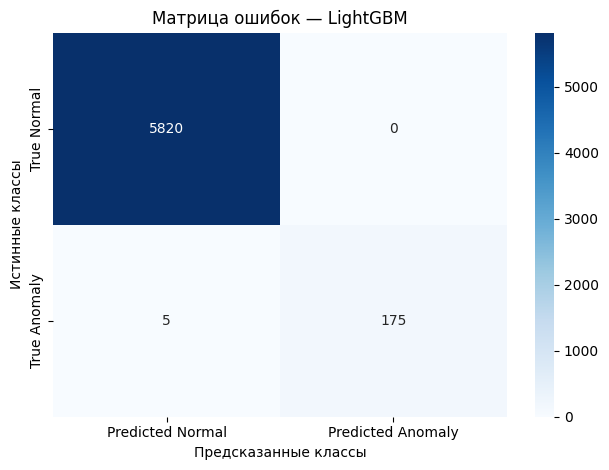

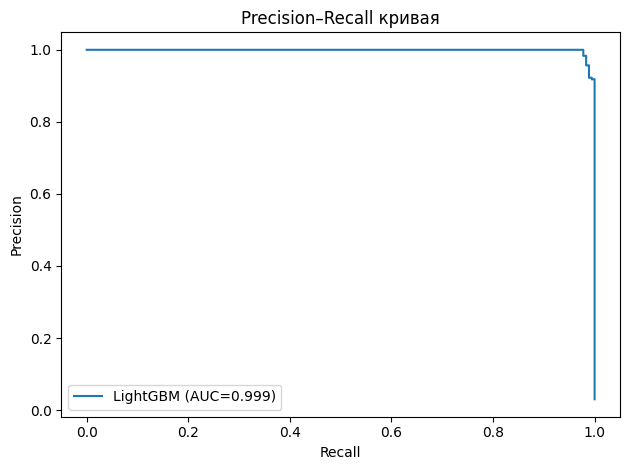

In [17]:
# LightGBM
lgbm = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE
)
lgbm.fit(X_train, y_train)

y_proba_lgbm = lgbm.predict_proba(X_test)[:, 1]
y_pred_lgbm = (y_proba_lgbm >= 0.5).astype(int)

metrics_lgbm = evaluate_and_print(y_test, y_pred_lgbm, y_proba_lgbm, "LightGBM")
plot_confusion_matrix(y_test, y_pred_lgbm, "Матрица ошибок — LightGBM")
pr_auc_lgbm = plot_pr_curve(y_test, y_proba_lgbm, "LightGBM")


### 4.2) Random Forest - Supervised Model. Она строит много независимых деревьев решений и объединяет их прогнозы. Она снижает переобучение за счёт случайного отбора признаков и выборок, устойчива к шуму.


Оценка качества: Random Forest
Accuracy:  0.9975
Precision: 1.0000
Recall:    0.9167
F1-score:  0.9565
ROC-AUC:   1.0000
PR-AUC:    0.9988

Classification report:
              precision    recall  f1-score   support

           0     0.9974    1.0000    0.9987      5820
           1     1.0000    0.9167    0.9565       180

    accuracy                         0.9975      6000
   macro avg     0.9987    0.9583    0.9776      6000
weighted avg     0.9975    0.9975    0.9974      6000



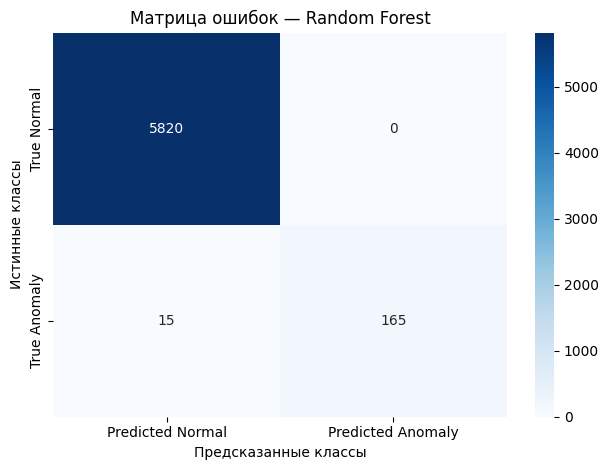

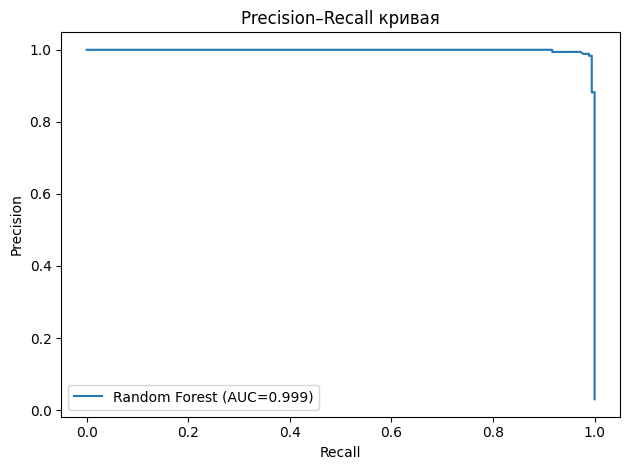

In [18]:
# Random Forest

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_proba_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_proba_rf >= 0.5).astype(int)

metrics_rf = evaluate_and_print(y_test, y_pred_rf, y_proba_rf, "Random Forest")
plot_confusion_matrix(y_test, y_pred_rf, "Матрица ошибок — Random Forest")
pr_auc_rf = plot_pr_curve(y_test, y_proba_rf, "Random Forest")


### 4.3) Isolation Forest - Semi-supervised Model. Метод, который ищет аномалии, изолируя точки данных с помощью множества случайных деревьев. Аномальные объекты изолируются быстрее, потому что они отличаются от основной массы


Оценка качества: Isolation Forest
Accuracy:  0.9485
Precision: 0.2655
Recall:    0.4056
F1-score:  0.3209
ROC-AUC:   0.9020
PR-AUC:    0.2538

Classification report:
              precision    recall  f1-score   support

           0     0.9813    0.9653    0.9732      5820
           1     0.2655    0.4056    0.3209       180

    accuracy                         0.9485      6000
   macro avg     0.6234    0.6854    0.6471      6000
weighted avg     0.9598    0.9485    0.9537      6000



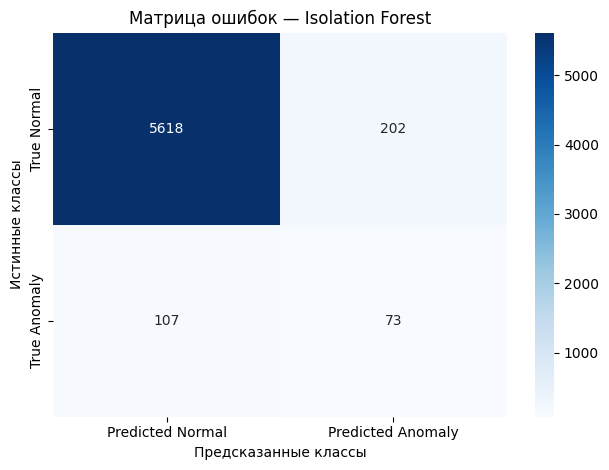

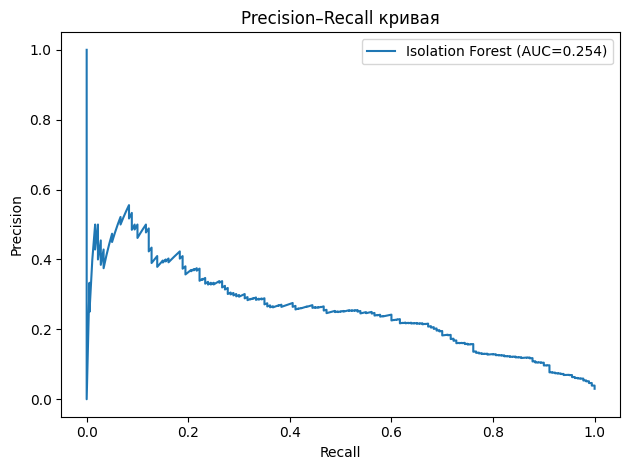

In [21]:
# Isolation Forest
iso = IsolationForest(
    n_estimators=200,
    contamination=CONTAMINATION,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

X_train_normals = X_train[y_train == 0]

iso.fit(X_train_normals)
# predict возвращает 1 (нормальные), -1 (аномалии)
y_pred_iso = iso.predict(X_test)
y_pred_iso_bin = (y_pred_iso == -1).astype(int)
scores_iso = -iso.decision_function(X_test)

metrics_iso = evaluate_and_print(y_test, y_pred_iso_bin, scores_iso, "Isolation Forest")
plot_confusion_matrix(y_test, y_pred_iso_bin, "Матрица ошибок — Isolation Forest")
pr_auc_iso = plot_pr_curve(y_test, scores_iso, "Isolation Forest")


### Проводим нормализацию для основанных на расстоянии моделей

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4.4) DBSCAN - Unsupervised Model. Алгоритм кластеризации на основе плотности, который группирует точки, находящиеся близко друг к другу, и помечает изолированные точки как аномалии. Он не требует заранее задавать число кластеров.


Оценка качества: DBSCAN
Accuracy:  0.8780
Precision: 0.1856
Recall:    0.9056
F1-score:  0.3081
ROC-AUC:   0.8914
PR-AUC:    0.5470

Classification report:
              precision    recall  f1-score   support

           0     0.9967    0.8771    0.9331      5820
           1     0.1856    0.9056    0.3081       180

    accuracy                         0.8780      6000
   macro avg     0.5912    0.8914    0.6206      6000
weighted avg     0.9724    0.8780    0.9144      6000



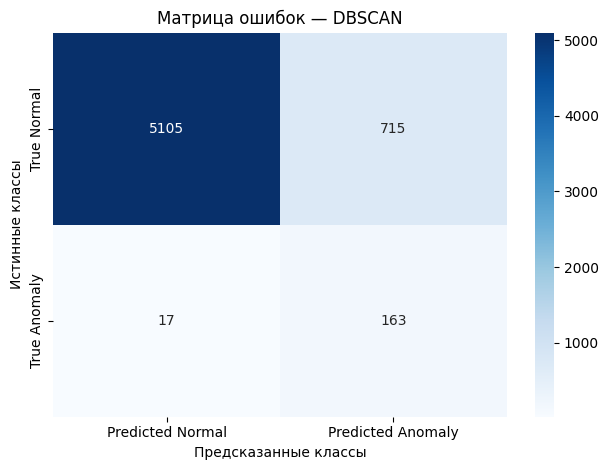

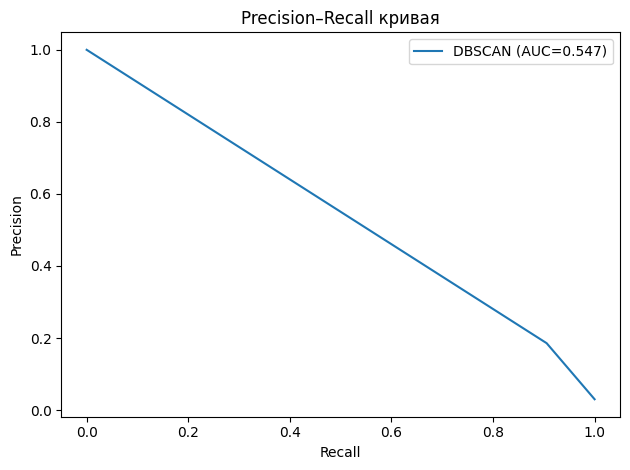

In [23]:
# DBSCAN не даёт вероятностей. Используем бинаризацию: -1 -> аномалия.
dbscan = DBSCAN(eps=10, min_samples=5, n_jobs=-1)
dbscan.fit(X_test_scaled)
dbscan_labels = dbscan.labels_
y_pred_dbscan = (dbscan_labels == -1).astype(int)

# Для ROC-AUC/PR используем: 1 для -1 (аномалия), 0 иначе
scores_dbscan = (dbscan_labels == -1).astype(int)

metrics_dbscan = evaluate_and_print(y_test, y_pred_dbscan, scores_dbscan, "DBSCAN")
plot_confusion_matrix(y_test, y_pred_dbscan, "Матрица ошибок — DBSCAN")
pr_auc_dbscan = plot_pr_curve(y_test, scores_dbscan, "DBSCAN")



### 4.5) Local Outlier Factor - Unsupervised Model. LOF — это алгоритм, который оценивает степень аномальности точки, сравнивая её локальную плотность с плотностью соседей. Объекты с заметно меньшей плотностью считаются выбросами.


Оценка качества: Local Outlier Factor (novelty=True)
Accuracy:  0.9613
Precision: 0.3523
Recall:    0.3444
F1-score:  0.3483
ROC-AUC:   0.9586
PR-AUC:    0.3704

Classification report:
              precision    recall  f1-score   support

           0     0.9797    0.9804    0.9801      5820
           1     0.3523    0.3444    0.3483       180

    accuracy                         0.9613      6000
   macro avg     0.6660    0.6624    0.6642      6000
weighted avg     0.9609    0.9613    0.9611      6000



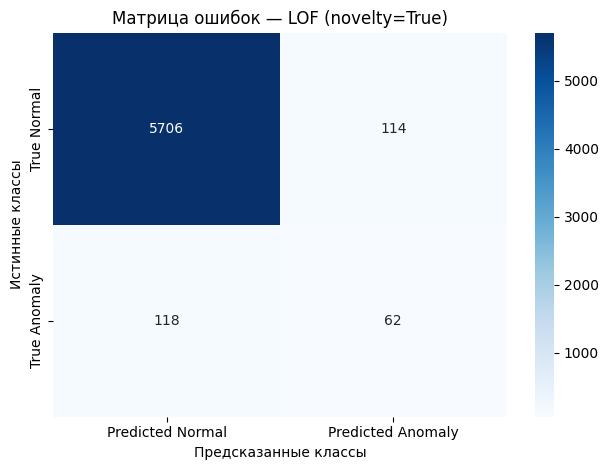

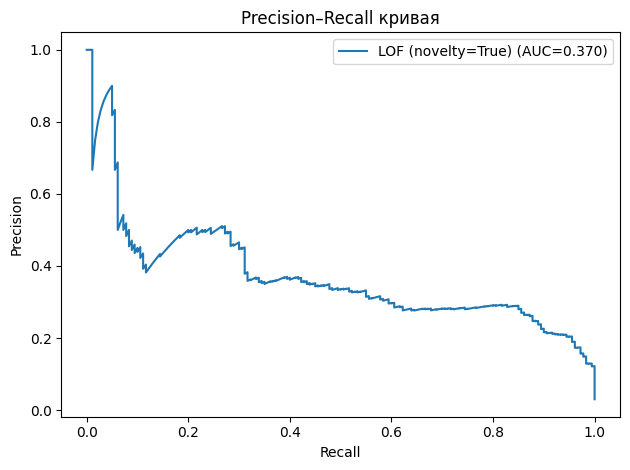

In [24]:
# LOF
lof = LocalOutlierFactor(
    n_neighbors=200,
    contamination=CONTAMINATION,
    novelty=True
)

lof.fit(X_train_scaled)

y_pred_lof = lof.predict(X_test_scaled)
y_pred_lof_bin = (y_pred_lof == -1).astype(int)

scores_lof = -lof.score_samples(X_test_scaled)

scores_lof = (scores_lof - scores_lof.min()) / (scores_lof.max() - scores_lof.min() + 1e-9)

metrics_lof = evaluate_and_print(y_test, y_pred_lof_bin, scores_lof, "Local Outlier Factor (novelty=True)")
plot_confusion_matrix(y_test, y_pred_lof_bin, "Матрица ошибок — LOF (novelty=True)")
pr_auc_lof = plot_pr_curve(y_test, scores_lof, "LOF (novelty=True)")


### 4.6) Gaussian Mixture Model - Unsupervised Model. GMM — это вероятностная модель, которая представляет данные как смесь нескольких нормальных распределений. Точки с низкой вероятностью принадлежности к любому из распределений считаются аномалиями.


Оценка качества: GMM
Accuracy:  0.9713
Precision: 0.5222
Recall:    0.5222
F1-score:  0.5222
ROC-AUC:   0.9623
PR-AUC:    0.6015

Classification report:
              precision    recall  f1-score   support

           0     0.9852    0.9852    0.9852      5820
           1     0.5222    0.5222    0.5222       180

    accuracy                         0.9713      6000
   macro avg     0.7537    0.7537    0.7537      6000
weighted avg     0.9713    0.9713    0.9713      6000



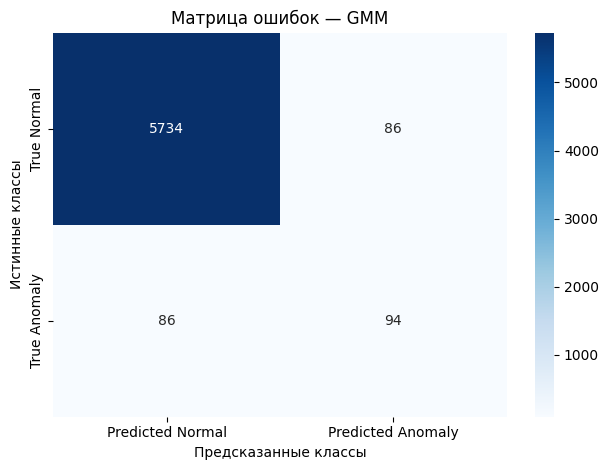

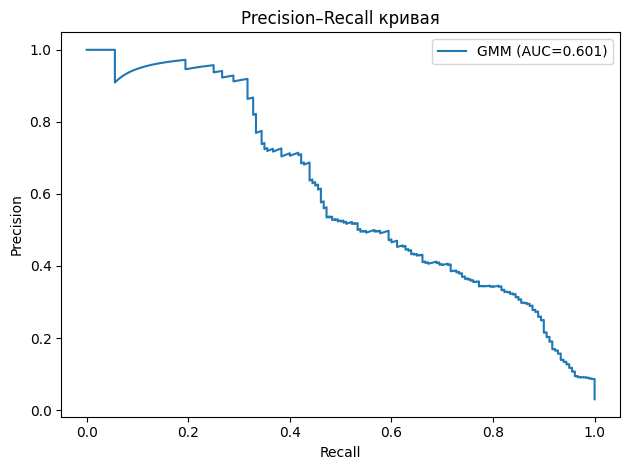

In [25]:
# GMM
gmm = GaussianMixture(
    n_components=2,
    covariance_type='full',
    random_state=RANDOM_STATE
)
gmm.fit(X_train_scaled)

anomaly_scores_gmm = -gmm.score_samples(X_test_scaled)

thr_gmm = np.percentile(anomaly_scores_gmm, (1 - CONTAMINATION) * 100)
y_pred_gmm = (anomaly_scores_gmm > thr_gmm).astype(int)

metrics_gmm = evaluate_and_print(y_test, y_pred_gmm, anomaly_scores_gmm, "GMM")
plot_confusion_matrix(y_test, y_pred_gmm, "Матрица ошибок — GMM")
pr_auc_gmm = plot_pr_curve(y_test, anomaly_scores_gmm, "GMM")


### 4.7) Histogram Based Outlier Score - Unsupervised Model. HBOS — это метод на основе гистограмм, который оценивает плотность значений каждого признака отдельно. Объекты с низкой совокупной плотностью считаются аномалиями.


Оценка качества: HBOS
Accuracy:  0.9527
Precision: 0.2719
Recall:    0.3444
F1-score:  0.3039
ROC-AUC:   0.8637
PR-AUC:    0.2089

Classification report:
              precision    recall  f1-score   support

           0     0.9796    0.9715    0.9755      5820
           1     0.2719    0.3444    0.3039       180

    accuracy                         0.9527      6000
   macro avg     0.6257    0.6580    0.6397      6000
weighted avg     0.9583    0.9527    0.9554      6000



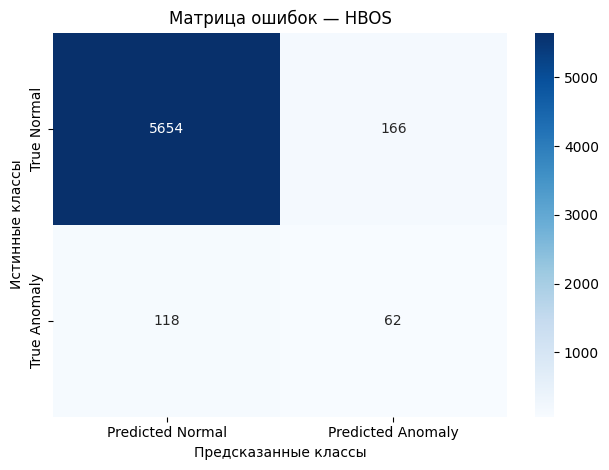

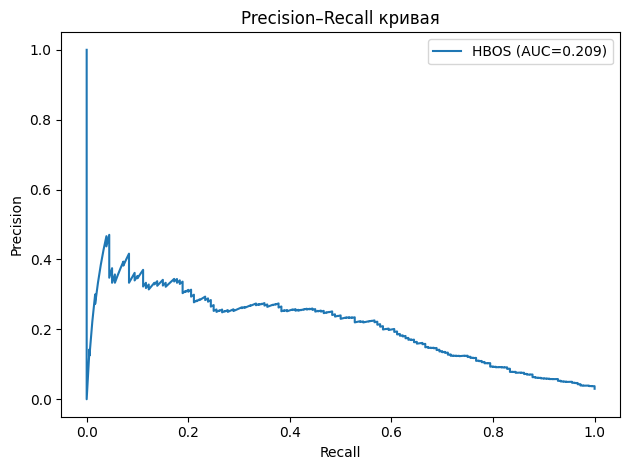

In [26]:
# HBOS
hbos = HBOS(contamination=CONTAMINATION)
hbos.fit(X_train_scaled)

y_pred_hbos = hbos.predict(X_test_scaled)
scores_hbos = hbos.decision_function(X_test_scaled)

metrics_hbos = evaluate_and_print(y_test, y_pred_hbos, scores_hbos, "HBOS")
plot_confusion_matrix(y_test, y_pred_hbos, "Матрица ошибок — HBOS")
pr_auc_hbos = plot_pr_curve(y_test, scores_hbos, "HBOS")

### 4.8) One Class Support Vector Machine - Semi-Supervised. Вариант метода опорных векторов, который обучается только на нормальных данных и ищет границу, отделяющую их от возможных аномалий. Точки, выходящие за эту границу, считаются выбросами.


Оценка качества: One-Class SVM
Accuracy:  0.9543
Precision: 0.3743
Recall:    0.7778
F1-score:  0.5054
ROC-AUC:   0.9669
PR-AUC:    0.5938

Classification report:
              precision    recall  f1-score   support

           0     0.9929    0.9598    0.9761      5820
           1     0.3743    0.7778    0.5054       180

    accuracy                         0.9543      6000
   macro avg     0.6836    0.8688    0.7407      6000
weighted avg     0.9743    0.9543    0.9619      6000



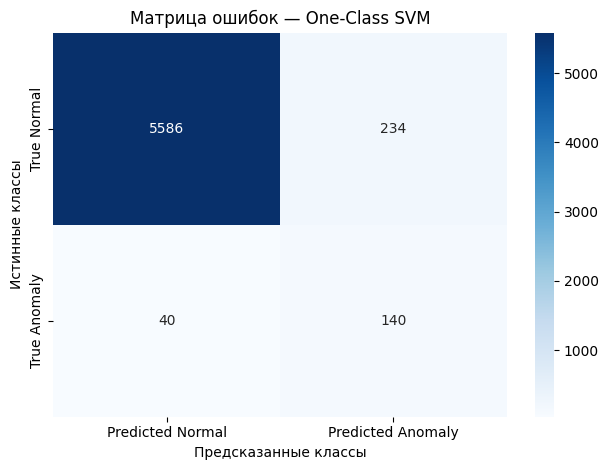

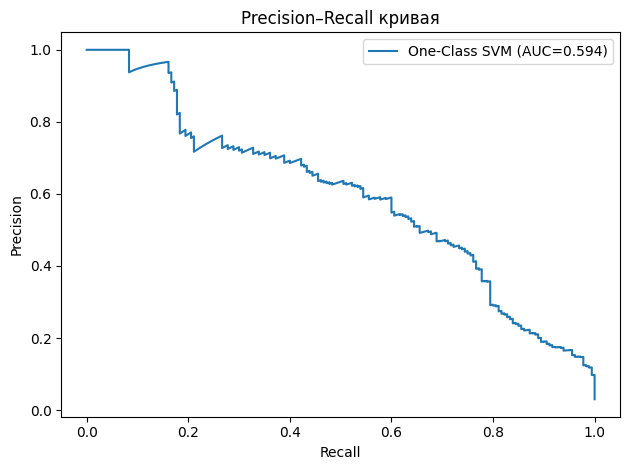

In [27]:
# One-Class SVM
X_train_normals = X_train_scaled[y_train == 0]

ocsvm = OneClassSVM(kernel='rbf', nu=CONTAMINATION, gamma='scale')
ocsvm.fit(X_train_normals)

y_pred_ocsvm = (ocsvm.predict(X_test_scaled) == -1).astype(int)
scores_ocsvm = -ocsvm.decision_function(X_test_scaled)

metrics_ocsvm = evaluate_and_print(y_test, y_pred_ocsvm, scores_ocsvm, "One-Class SVM")
plot_confusion_matrix(y_test, y_pred_ocsvm, "Матрица ошибок — One-Class SVM")
pr_auc_ocsvm = plot_pr_curve(y_test, scores_ocsvm, "One-Class SVM")


### 5) Сравнение метрик моделей

In [28]:
summary = pd.DataFrame([
    {"model": "LightGBM",         **metrics_lgbm,  "pr_auc": pr_auc_lgbm},
    {"model": "RandomForest",     **metrics_rf,    "pr_auc": pr_auc_rf},
    {"model": "DBSCAN",           **metrics_dbscan,"pr_auc": pr_auc_dbscan},
    {"model": "LOF",              **metrics_lof,   "pr_auc": pr_auc_lof},
    {"model": "IsolationForest",  **metrics_iso,   "pr_auc": pr_auc_iso},
    {"model": "GMM",              **metrics_gmm,   "pr_auc": pr_auc_gmm},
    {"model": "HBOS",             **metrics_hbos,  "pr_auc": pr_auc_hbos},
    {"model": "OC-SVM",           **metrics_ocsvm, "pr_auc": pr_auc_ocsvm},

]).set_index("model").round(4)

print("Сводка метрик (тест):")
display(summary.sort_values(by=["f1","roc_auc","pr_auc"], ascending=False))

Сводка метрик (тест):


,accuracy,precision,recall,f1,roc_auc,pr_auc
model,,,,,,
LightGBM,0.9992,1.0000,0.9722,0.9859,1.0000,0.9988
RandomForest,0.9975,1.0000,0.9167,0.9565,1.0000,0.9988
GMM,0.9713,0.5222,0.5222,0.5222,0.9623,0.6015
OC-SVM,0.9543,0.3743,0.7778,0.5054,0.9669,0.5938
LOF,0.9613,0.3523,0.3444,0.3483,0.9586,0.3704
IsolationForest,0.9485,0.2655,0.4056,0.3209,0.9020,0.2538
DBSCAN,0.8780,0.1856,0.9056,0.3081,0.8914,0.5470
HBOS,0.9527,0.2719,0.3444,0.3039,0.8637,0.2089


###Графическое сравнение

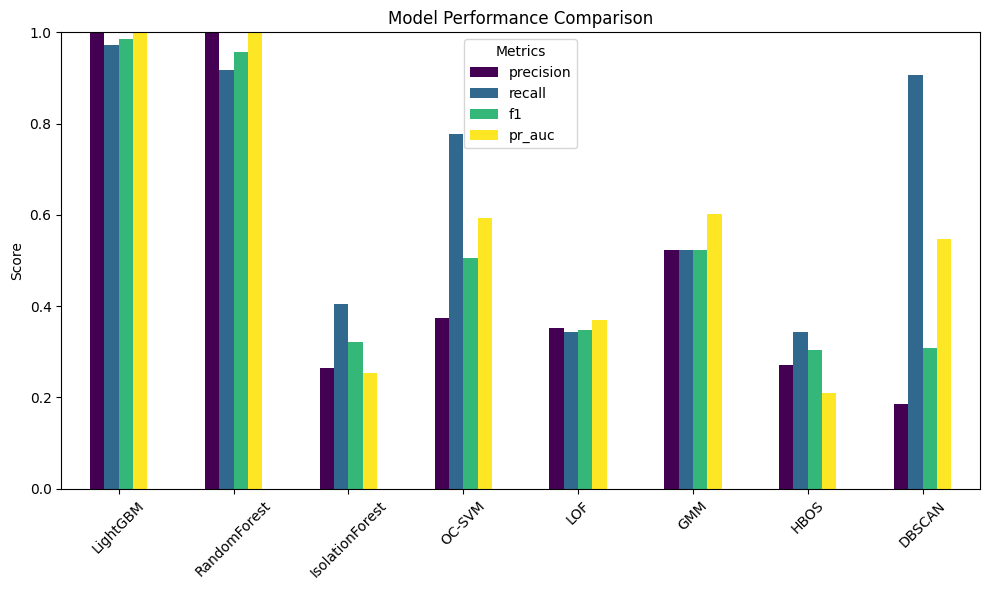

In [29]:
results = {
    'LightGBM': metrics_lgbm,
    'RandomForest': metrics_rf,
    'IsolationForest': metrics_iso,
    'OC-SVM': metrics_ocsvm,
    'LOF': metrics_lof,
    'GMM': metrics_gmm,
    'HBOS': metrics_hbos,
    'DBSCAN': metrics_dbscan
}

df_results = pd.DataFrame(results).T

df_results[['precision', 'recall', 'f1', 'pr_auc']].plot(
    kind='bar',
    figsize=(10, 6),
    grid=False,
    rot=45,
    title='Model Performance Comparison',
    colormap='viridis',
)

plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()

### BONUS
Оценим Confusion Matrix, если бы мы искали аномалии с помощью вручную написанных правил на основе 6 видов предложенных аномалий (см. блок 2) функция rule_category)

In [30]:
def rule_category(row: pd.Series) -> str:
    v = lambda c, default=None: row.get(c, default)

    if v('channel') == 'eCommerce' and v('is_night') == 1 and v('is_3ds') == 0 and v('amount_mdl', 0) > 650:
        return 'ECOM_NIGHT_NO3DS_HIGHAMT'
    if v('geo_distance_km', 0) > 3000 and v('merchant_country') == 'MD':
        return 'IMPOSSIBLE_TRAVEL'
    if v('new_device_flag') == 1 and v('ip_risk_score', 0) >= 0.6 and v('cross_border') == 1:
        return 'NEW_DEVICE_IP_CROSS'
    if v('channel') == 'POS' and v('auth_method') == 'MAGSTRIPE' and v('is_night') == 1 and v('merchant_category') not in [None, 'Grocery', 'Home&Garden', 'Restaurants', 'Pharmacy', 'Transport/Taxi']:
        return 'POS_MAGSTRIPE_NIGHT'
    if v('merchant_country') == 'AE' and v('currency') not in [None, 'MDL', 'EUR', 'UAH', 'RON']:
        return 'RARE_COUNTRY_CCY'
    if v('txn_count_1h', 0) >= 10 or v('txn_amount_24h', 0) > 40:
        return 'VELOCITY_BURST'
    return 'NORMAL'

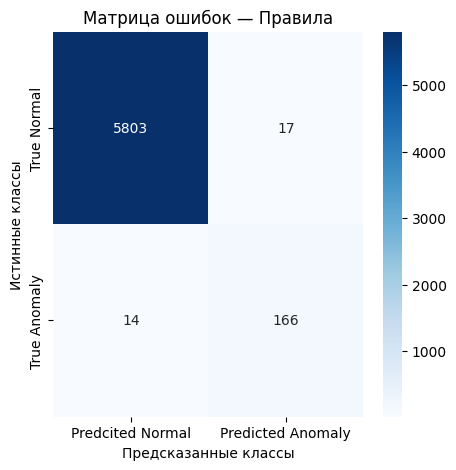

Качество rule-based логики:
Precision: 0.9071
Recall   : 0.9222
F1-score : 0.9146


In [31]:
# Rules

df_test_rules = df.iloc[test_idx].copy()
df_test_rules['rule_category'] = df_test_rules.apply(rule_category, axis=1)
df_test_rules['rule_label'] = (df_test_rules['rule_category'] != 'NORMAL').astype(int)

y_true = y_test.values
y_pred_rule = df_test_rules['rule_label'].values

cm_rules = confusion_matrix(y_true, y_pred_rule)
plt.figure(figsize=(5, 5))
sns.heatmap(
    cm_rules,
    annot=True, fmt='d', cmap='Blues',
    xticklabels=['Predcited Normal', 'Predicted Anomaly'],
    yticklabels=['True Normal', 'True Anomaly']
)
plt.title("Матрица ошибок — Правила")
plt.xlabel("Предсказанные классы")
plt.ylabel("Истинные классы")
plt.show()

precision_rule = precision_score(y_true, y_pred_rule, zero_division=0)
recall_rule = recall_score(y_true, y_pred_rule, zero_division=0)
f1_rule = f1_score(y_true, y_pred_rule, zero_division=0)

print("Качество rule-based логики:")
print(f"Precision: {precision_rule:.4f}")
print(f"Recall   : {recall_rule:.4f}")
print(f"F1-score : {f1_rule:.4f}")


## **Вывод**: Для Деплоя будет использоваться самая перформантная модель - LightGBM

# 6. Deployment

Ссылка на Deploy: https://fastapiprojectdatastorm2025.onrender.com/